In [60]:
# micrograd from scratch 
# its a library released by Andrej. he is gonna help connect all the pieces
# it implements backprop
# 


In [61]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [143]:
# defining the Value class
class Value:
    def __init__(self,data,_children=(), _op = '', label = ''):
        self.data = data
        self._backward = lambda:None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self,other):
        out = Value((self.data + other.data),(self,other),'+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value((self.data * other.data),(self,other),'*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        n= self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t,(self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f ; L.label = 'L'
L


Value(data = -8.0)

In [123]:
from graphviz import Digraph

def trace(root):
#     //builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    
    dot = Digraph(format ='svg', graph_attr = {'rankdir': 'LR'}) #LR = LEFT TO RIGHT
    
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
#         for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label= "{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape ='record')
        if n._op:
#             if this value is the result of some operation, create an op node for it.
            dot.node(name = uid+n._op, label = n._op)
#             and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot

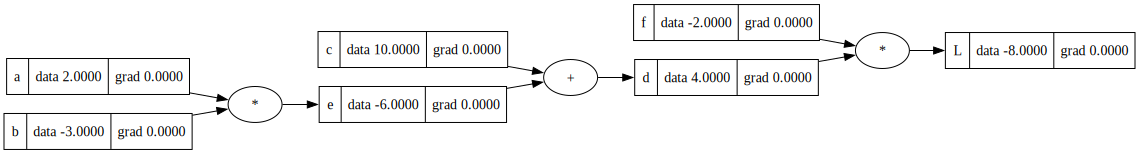

In [124]:
draw_dot(L)

In [126]:
# we need to calculate dL/dc




we calculate the derivative of L, wrt the change in the particular node(e.g. A). basically we are calulating dL/dx -> given a small change in x.

L = d * f
dL/dd = f



In [146]:
o.backward()

In [140]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [102]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad 

In [104]:
x2.grad = w2.data * x2w2.grad 
w2.grad = x2.data * x2w2.grad

In [97]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [98]:
# backprop
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [ ]:
# o is tanh of n
# derivative of n wrt o
# do/dn = 1- tanh(n) **2 => 1 - o**2
# 
# derivative of b wrt o


In [ ]:
//